In [1]:
using JuMP, Gurobi, LinearAlgebra, Suppressor, StatsBase, Compat, Mosek, Random

In [2]:
include("exact_edm.jl") 
#Note that we minimize the sum of the slacks squared in the constraints, to ensure that we find a feasible solution

getEDMcut (generic function with 1 method)

In [3]:
include("convex_penalties_edm.jl")

getMatrixTraceNorm_EDM_Gram (generic function with 1 method)

Given a set of distances between a set of sensor points (i,j) and anchor points, and a set of anchor points, our task is to generate a feasible realization of the sensor points. This is equivalent to solving a low-rank euclidean distance matrix completion problem. Let us first consider solving such a problem using a trace norm heuristic.

# The random links problem

In [21]:

n=20 #Number of points located on the grid
m=0 #Number of anchors located on the grid

xs=rand(n, 2).-0.5 #generate n random points in 2 dimensional space uniformly distributed on [-0.5, 0.5)
ys=rand(m, 2).-0.5 #generate m random anchor points in 2 dimensional space uniformly distributed on [-0.5, 0.5)
zs=[ys; xs]
D=zeros(n+m,n+m) #the matrix we would like to recover.
for i=1:(n+m) #in a loop is slightly slower, but unimportant
    for j=1:(i-1)
        D[i,j]=norm(zs[i,:].-zs[j,:])^2
        D[j,i]=norm(zs[i,:].-zs[j,:])^2
    end
end

p=0.06
#k=2
numEntriesSampled=Int(round(p*(n+m)^2))

# Get observed set of coordinates
coords=[repeat(1:(n+m), inner=size(1:(n+m),1)) repeat(1:(n+m), outer=size(1:(n+m),1))];
entries=sample(1:(n+m)^2, Int(numEntriesSampled), replace=false);

In [22]:
# Verifying the primal/dual formulation for the inner problem in the exact method
# primal formulation
lambda=1.0

m=Model(Mosek.Optimizer)
@variable(m, G[1:n, 1:n], PSD)
@variable(m, g[1:n])
@variable(m, slack[1:n, 1:n])
@variable(m, absslack[1:n, 1:n])
@constraint(m, absslack.>=slack)
@constraint(m, absslack.>=-slack)
@constraint(m, imposeDiag[i=1:n], G[i,i]==g[i])
# Impose constraint on Gram matrix for entries sampled
for t=1:numEntriesSampled
    i=coords[entries[t],1]
    j=coords[entries[t],2]
   @constraint(m, g[i]+g[j]-2*G[i,j]+slack[i,j]==D[i,j]) 
end

@objective(m, Min, sum(g)+lambda*sum(absslack)) # Minimize the trace of the matrix
optimize!(m)
@show objective_value(m)


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 844             
  Cones                  : 0               
  Scalar variables       : 820             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 800
Eliminator terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 2                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective 

1.5442657511624847

In [28]:
# dual formulation
m2=Model(Mosek.Optimizer)
@variable(m2, Pi[1:n, 1:n], Symmetric)
@variable(m2, rho[1:n])
@constraint(m2, Pi*ones(n).==rho)
@constraint(m2, Pi.<=lambda)
@constraint(m2, -Pi.<=lambda)
@objective(m2, Max, Compat.dot(Pi, D))
@constraint(m2, (2.0*Pi.+diagm(ones(n))-2.0*diagm(rho)) in PSDCone())

# Impose constraint to reflect that we don't have all the data
theIndices=zeros(n,n)
for t=1:Int(numEntriesSampled)
    theIndices[coords[entries[t],1], coords[entries[t],2]]=1.0
    theIndices[coords[entries[t],2], coords[entries[t],1]]=1.0 #Remark: note from Ryan-we do need both coords!
end
@constraint(m2, Pi.*(ones(n,n).-theIndices).==0.0)
# @show theIndices

optimize!(m2)
@show objective_value(m2)

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1430            
  Cones                  : 0               
  Scalar variables       : 230             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 19
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimiza

1.5449656247161374

In [5]:
# Solve the sdp relaxation, display the rank, relative MSE
X_imputed, G_imputed,=getMatrixTraceNorm_EDM(coords, entries, D, n, numEntriesSampled, ys, m);

In [6]:
@show err_XTR=norm(X_imputed.-xs)/norm(xs);
D_imputed=diag(G_imputed)*ones(n)'+ones(n)*diag(G_imputed)'.-2*G_imputed
@show err_DTR=norm(D_imputed.-D[m+1:end, m+1:end])/norm(D[m+1:end, m+1:end])

err_XTR = norm(X_imputed .- xs) / norm(xs) = 0.8105838745606148
err_DTR = norm(D_imputed .- D[m + 1:end, m + 1:end]) / norm(D[m + 1:end, m + 1:end]) = 0.7640376396424784


0.7640376396424784

In [31]:
# Plot the points
using Plots
gr()

Plots.GRBackend()

In [8]:
p1=scatter(xs[:,1], xs[:,2], label="Real sensors", legend=:outertopright)
scatter!(p1, X_imputed[:,1], X_imputed[:,2], label="Imputed sensors")
scatter!(p1, ys[:,1], ys[:,2], label="Anchors")

for i=1:n
    theXs=[xs[i,1]; X_imputed[i,1]]
    theYs=[xs[i,2]; X_imputed[i,2]]
    plot!(p1, theXs, theYs, label="", line=(:dot, 4))
end

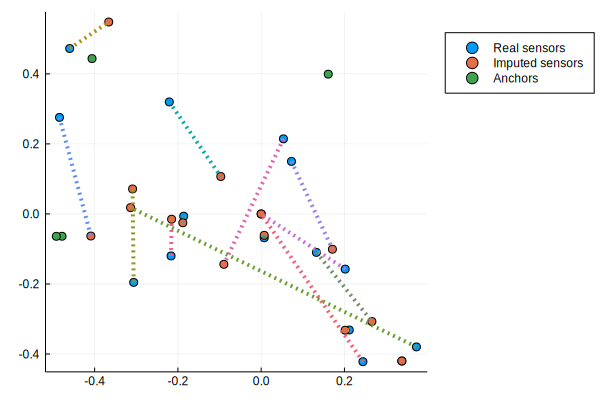

In [9]:
p1

In [ ]:
@time X_imputed, G_imputed,=getMatrixExact_EDM(coords, entries, D, n, numEntriesSampled, ys, m);

size(x * y') = (70, 70)
size(G[3:n + num_anchors + 2, 3:n + num_anchors + 2]) = (70, 70)


In [ ]:
@show err_XTR=norm(X_imputed.-xs)/norm(xs);
D_imputed=diag(G_imputed)*ones(n)'+ones(n)*diag(G_imputed)'.-2*G_imputed
@show err_DTR=norm(D_imputed.-D[m+1:end, m+1:end])/norm(D[m+1:end, m+1:end])

In [12]:
p1=scatter(xs[:,1], xs[:,2], label="Real sensors", legend=:outertopright)
scatter!(p1, X_imputed[:,1], X_imputed[:,2], label="Imputed sensors")
scatter!(p1, ys[:,1], ys[:,2], label="Anchors")

for i=1:n
    theXs=[xs[i,1]; X_imputed[i,1]]
    theYs=[xs[i,2]; X_imputed[i,2]]
    plot!(p1, theXs, theYs, label="", line=(:dot, 4))
end

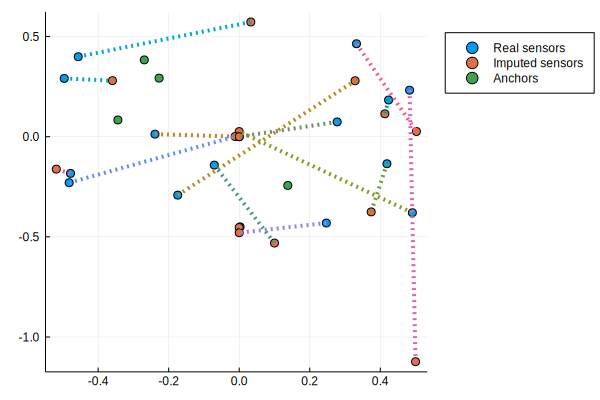

In [13]:
p1

# Radio range problem with corrupted distances
In this version of the problem, we only know the distance between any two points in the graph if their distance is less than the "radio range".

In [94]:
Random.seed!(1234)
r=0.3
n=25 #Number of points located on the grid
m=2 #Number of anchors located on the grid

xs=rand(n, 2).-0.5 #generate n random points in 2 dimensional space uniformly distributed on [-0.5, 0.5)
ys=rand(m, 2).-0.5 #generate m random anchor points in 2 dimensional space uniformly distributed on [-0.5, 0.5)
zs=[ys; xs]
D=zeros(n+m,n+m) #the matrix we would like to recover.
for i=1:(n+m) #in a loop is slightly slower, but unimportant
    for j=1:(i-1)
        D[i,j]=max(0.0, norm(zs[i,:].-zs[j,:])^2+0.01*(randn(1)[1]))
        D[j,i]=D[i,j]
    end
end



# Get observed set of coordinates
coords=[repeat(1:(n+m), inner=size(1:(n+m),1)) repeat(1:(n+m), outer=size(1:(n+m),1))];
entries=Int[]
for i=1:(n+m)^2
    if norm(D[coords[i,1], coords[i,2]])<=r^2
        push!(entries, i)
    end
end

numEntriesSampled=size(entries,1)
    

189

In [95]:
# Solve the sdp relaxation 
X_imputed, G_imputed,=getMatrixTraceNorm_EDM_noisy(coords, entries, D, n, numEntriesSampled, ys, m, true, 0.4);

In [96]:
X_ws=X_imputed;

In [97]:
@show err_XTR=norm(X_imputed.-xs)/norm(xs);
D_imputed=diag(G_imputed)*ones(n)'+ones(n)*diag(G_imputed)'.-2*G_imputed
@show err_DTR=norm(D_imputed.-D[m+1:end, m+1:end])/norm(D[m+1:end, m+1:end])

err_XTR = norm(X_imputed .- xs) / norm(xs) = 0.5416681287438367
err_DTR = norm(D_imputed .- D[m + 1:end, m + 1:end]) / norm(D[m + 1:end, m + 1:end]) = 0.44942809680604295


0.44942809680604295

In [98]:
p1=scatter(xs[:,1], xs[:,2], label="Real sensors", legend=:outertopright)
scatter!(p1, X_imputed[:,1], X_imputed[:,2], label="Imputed sensors")
scatter!(p1, ys[:,1], ys[:,2], label="Anchors")

for i=1:n
    theXs=[xs[i,1]; X_imputed[i,1]]
    theYs=[xs[i,2]; X_imputed[i,2]]
    plot!(p1, theXs, theYs, label="", line=(:dot, 4))
end

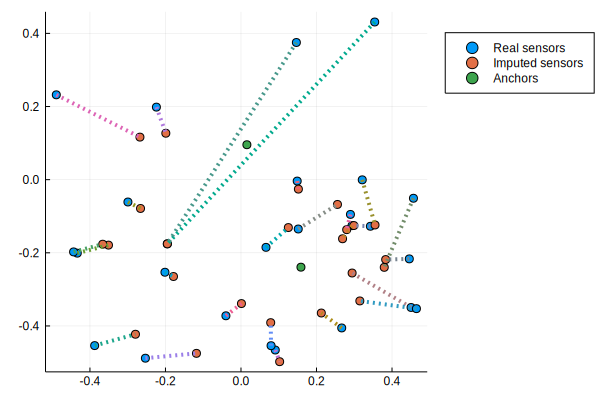

In [99]:
p1

In [100]:
savefig("impute_sensorlocation_n25_m2_r0p3_trace.pdf")

In [101]:
# Test out the BM approach
@show size([ys;X_ws])

size([ys; X_ws]) = (27, 2)


(27, 2)

In [ ]:
@time X_imputed, G_imputed,=getMatrixExact_EDM(coords, entries, D, n, numEntriesSampled, ys, m, [ys;X_ws], true, 0.4);

size(x * y') = (27, 27)
size(G[3:n + num_anchors + 2, 3:n + num_anchors + 2]) = (27, 27)


In [ ]:
@show err_ex=norm(X_imputed.-xs)/norm(xs);
D_imputed=diag(G_imputed)*ones(n)'+ones(n)*diag(G_imputed)'.-2*G_imputed
@show err_ex=norm(D_imputed.-D[m+1:end, m+1:end])/norm(D[m+1:end, m+1:end])

In [ ]:
p1=scatter(xs[:,1], xs[:,2], label="Real sensors", legend=:outertopright)
scatter!(p1, X_imputed[:,1], X_imputed[:,2], label="Imputed sensors")
scatter!(p1, ys[:,1], ys[:,2], label="Anchors")

for i=1:n
    theXs=[xs[i,1]; X_imputed[i,1]]
    theYs=[xs[i,2]; X_imputed[i,2]]
    plot!(p1, theXs, theYs, label="", line=(:dot, 4))
end

In [ ]:
p1

In [ ]:
savefig("impute_sensorlocation_n25_m2_r0p3_exact.pdf")